# Encontrando las Líneas en la Carretera

---
Los líneas en las carreteras y autopistas son de las pistas visuales más importantes con las que cuenta un vehículo autónomo. Es por este motivo que es vital poder identificarlas con precisión en una imagen o en un video para poder llevar a cabo acciones con base en decisiones más informadas.

Veamos nuestra primera imagen:

---


<figure>
 <img src="resources/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Nuestra meta es conectar/promediar/extrapolar segmentos de línea para producir un resultado como este.</p> 
 </figcaption>
</figure>

In [1]:
# Importemos algunas librerías útiles
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

Esta imagen: <class 'numpy.ndarray'> tiene dimensiones: (540, 960, 3)


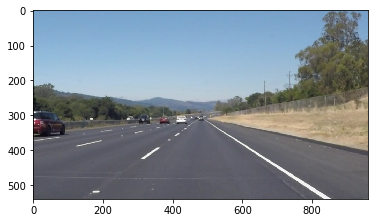

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('Esta imagen:', type(image), 'tiene dimensiones:', image.shape)
plt.imshow(image)  # Llamar como plt.imshow(gray, cmap='gray') para mostrar en escala de grises.

Bien. Recibiremos imágenes como esta provenientes de una cámara montada sobre el capó de nuestro carro autónomo. Nuestro objetivo es, entonces, dibujar líneas de color sobre las líneas verdaderas del camino para evaluar cuán bien están siendo detectadas por nuestro algoritmo.

Con ese fin utilizaremos diversas funciones de OpenCV que facilitarán nuestras vidas.

**Algunas funciones de OpenCV que usaremos a lo largo de este proyecto son:**

`cv2.inRange()` para selección de color.

`cv2.fillPoly()` para selección de región.

`cv2.line()` para dibujar líneas sobre una imagen dados sus vértices. 

`cv2.addWeighted()` para superponer dos imágenes.

`cv2.cvtColor()` para pasar a otro espacio de color.

`cv2.imwrite()` para guardar imágenes en disco.

`cv2.bitwise_and()` para aplicar una máscara sobre una imagen. 

**Revisa la documentación de OpenCV para aprender más sobre éstas y otras funcionas aún más increíbles.**

Abajo encontrarás algunas funciones auxiliares para hacer todo más sencillo: 

In [3]:
import math


def transform_color_space(img, space='gray'):
    """
    Transforma imágenes a otro espacio de color. Sólo soporta gray y hsv.
    """
    if space == 'gray':
        space_transform = cv2.COLOR_BGR2GRAY
    elif space == 'hsv':
        space_transform = cv2.COLOR_BGR2HSV
        
    return cv2.cvtColor(img, space_transform)
    
def canny(img, low_threshold, high_threshold):
    """Aplica Canny Edge Detection,"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Aplica un Guassian Noise kernel."""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Aplica una máscara sobre una imagen.
    
    Solo conserva la region de la imagen definida por el polígono formado por los puntos en `vertices`. 
    El resto de los pixeles se colocan en negro. 
    """
    # Máscara inicial.
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Rellena los pixeles dentro del polígono con el color de la máscara.
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning la imagen original preservando aquellos pixeles que no son cero en la máscara.
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_region(img, vertices):
    """Dibuja la región de interés delimitada por `vertices` sobre `img`"""
    masked_image = region_of_interest(img, vertices)
    plt.imshow(masked_image, cmap='hsv')
    

def get_slope(line):
    """Calcula la pendiente de una línea."""
    x1, y1, x2, y2 = line
    
    return (y2 - y1) / (x2 - x1)

def build_line(slopes, xs, ys, y_min, y_max):
    """
    Construye una línea que representa la 'línea promedio' de los parámetros de entrada.
    """

    if slopes != []:
        m = np.mean(slopes)
    else:
        m = 1

    if xs != []:
        x_mean = np.mean(xs)
    else:
        x_mean = 1

    if ys != []:
        y_mean = np.mean(ys)
    else:
        y_mean = y_min

    b = y_mean - m * x_mean
    x_max = (y_max - b) / m
    x_min = (y_min - b) / m
        
    return (x_min, y_min, x_max, y_max)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Dibuja líneas sólidas sobre la imagen.
    """
    # Acumuladores para la línea de la izquierda.
    left_slopes = []
    left_xs = []
    left_ys = []
    
    # Acumuladores para la línea de la derecha.
    right_slopes = []
    right_xs = []
    right_ys = []
    
    for l in lines:
        line = l[0]
        x1, y1, x2, y2 = line  # Desempaca los valores.
        m = get_slope(line)
        
        # Sólo considera líneas con pendientes en este rango.
        if 0.2 <= abs(m) <= 0.8: 
            if m > 0:
                left_slopes.append(m)
                left_xs += [x1, x2]
                left_ys += [y1, y2]
            else:
                right_slopes.append(m)
                right_xs += [x1, x2]
                right_ys += [y1, y2]
            
    y_min_global = min(left_ys + right_ys)
    y_max_global = img.shape[0]

    
    # Construye la línea izquierda.
    lx1, ly1, lx2, ly2 = build_line(left_slopes, left_xs, left_ys, y_min_global, y_max_global)

    # Construye la línea derecha.
    rx1, ry1, rx2, ry2 = build_line(right_slopes, right_xs, right_ys, y_min_global, y_max_global)

    # Dibuja ambas líneas.
    cv2.line(img, (math.floor(lx1), math.floor(ly1)), (math.floor(lx2), math.floor(ly2)), color, thickness)
    cv2.line(img, (math.ceil(rx1), math.ceil(ry1)), (math.ceil(rx2), math.ceil(ry2)), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` debe ser la salida del Canny Edge Detector..
        
    Retorna una imagen en blanco sobre la cual dibujar, y un arreglo de líneas encontradas por el algoritmo Hough Transform.
    """
    lines = cv2.HoughLinesP(img,
                            rho,
                            theta, 
                            threshold, 
                            np.array([]), 
                            minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

    return line_img, lines

# Python 3 has soporta símbolos matemáticos cool.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` es el resultado de hough_lines(), una imagen con líneas dibujadas sobre ella.
    Debería ser una imagen en "blanco" (todos los pixeles en negro).
    
    `initial_img` debe ser la imagen original, sin ningún procesamiento. 
    
    La imagen resultante se calcula así: The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTA: initial_img e img deben tener las mismas dimensiones.
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Aquí está la definición de nuestro pipeline:



In [4]:
def _merge_with_defaults(parameters=None):
    defaults = {
        'canny_edge_thresholds': (50, 150),
        'kernel_size': 3,
        'vertices':np.array([[(107, Y_length), (460, 311), (500, 311), (930, Y_length)]], dtype=np.int32),
        'rho': 1,
        'theta': np.pi / 180,
        'hough_threshold': 20,
        'min_line_length': 100,
        'max_line_gap': 160,
        'line_thickness': 3,
        'space': 'gray'}
        
    if not parameters:
        # Simplemente usemos los valores por defecto.
        params = defaults
    else:
        # Mezcla los parámetros de entrada con los valores por defecto.
        params = dict()
        params['canny_edge_thresholds'] = parameters.get('canny_edge_thresholds', defaults['canny_edge_thresholds'])
        params['kernel_size'] = parameters.get('kernel_size', defaults['kernel_size'])
        params['vertices'] = parameters.get('vertices', defaults['vertices'])
        params['rho'] = parameters.get('rho', defaults['rho'])
        params['theta'] = parameters.get('theta', defaults['theta'])
        params['hough_threshold'] = parameters.get('hough_threshold', defaults['hough_threshold'])
        params['min_line_length'] = parameters.get('min_line_length', defaults['min_line_length'])
        params['max_line_gap'] = parameters.get('max_line_gap', defaults['max_line_gap'])
        params['line_thickness'] = parameters.get('line_thickness', defaults['line_thickness'])
        params['space'] = parameters.get('space', defaults['space'])
        
    return params


def find_lane_lines(image, parameters=None):
    """
    Encuentra las líneas del camino en una imagen.
    
    El formato del dict de parámetros debe ser así (ejemplo):
    parameters = {
        # Parámetros para Canny Edge.
        'canny_edge_thresholds': (60, 180),
        # Parámetros para Gaussian blur.
        'kernel_size': 7,
        # Parámetros para la máscara.
        'vertices': np.array([[(110, Y_length), (410, 350), (570, 350), (900, Y_length)]], dtype=np.int32),
        # Parámetros para Hough Transform.
        'rho': 1,
        'theta': np.pi / 180,
        'hough_threshold': 10,
        'min_line_length': 15,
        'max_line_gap': 20
    }
    
    Si parameters es None, entonces los valores por defecto serán utilizados. Si sólo algunos parámetros son pasados, éstos
    serán usados en combinación con los valores por defecto para los parámetros indefinidos
    """
    Y_length, X_length, _ = image.shape
    
    params = _merge_with_defaults(parameters)
        
    # Pasemos la imagen a escala de grises.
    transformed_image = transform_color_space(image, params['space'])
    
    # Ahora, difuminémosla.
    blurred_image = gaussian_blur(transformed_image, params['kernel_size'])
    
    # Applica Canny Edges:
    low_threshold, high_threshold = params['canny_edge_thresholds']
    edges_image = canny(blurred_image, low_threshold, high_threshold)
    
    masked_image = region_of_interest(edges_image, params['vertices'])
    
    lines_img, lines = hough_lines(masked_image, 
                                   params['rho'], 
                                   params['theta'],
                                   params['hough_threshold'], 
                                   params['min_line_length'],
                                   params['max_line_gap'])
    
    draw_lines(lines_img, lines, thickness=params['line_thickness'])
    
    # Retorna la imagen original con las líneas dibujadas encima.
    return weighted_img(lines_img, image)
    

## Prueba en Imágenes

Para estar seguros de que nuestro pipeline funciona a la perfección, lo probaremos con las imágenes presentes en `test_images`.

In [5]:
import os
for img in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + img)
    Y_length, X_length, _ = image.shape    
    cv2.imwrite("test_images_copy/copy_" + img, find_lane_lines(image))

## Prueba en Videos

¿Qué es más _cool_ que dibujar líneas sobre imánes? Dibujarlas sobre un video, **¡por supuesto!**

Podemos probar nuestra solución en dos videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Importemos todo lo necesario para editar/guardar/mirar extractos de video.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image, parameters=None):
    return find_lane_lines(image, parameters)

Probemos primero con la que tiene la línea blanca sólida a la derecha... Dado que un video es simplemente una serie de imágenes, nuestra función `process_image` será aplicada a cada cuadro (imagen) que compone al video. Para este fin, usaremos la librería `moviepy`.

In [8]:
clip1 = VideoFileClip("resources/solidWhiteRight.mp4")  # Carga el video de entrada

# Procesa cada frame.

# Para pasar parámetros diferentes, llámala así: 
# p = {...}
# white_clip = clip.fl_image(lambda i: process_image(i, p))
white_clip = clip1.fl_image(process_image) # NOTE: This function expects color images!

# Save produced video to disk.
white_output = 'resources/white.mp4'
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video resources/white.mp4
[MoviePy] Writing video resources/white.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: resources/white.mp4 

CPU times: user 1.83 s, sys: 253 ms, total: 2.08 s
Wall time: 18.4 s


Reproduce el video directamente en el Notebook o, si prefieres, búscalo en tu sistema de archivos y ponlo en tu reproductor favorito.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Ahora, vayamos con la que tiene la línea amarilla a la izquierda. ¡Esta es más difícil!

In [10]:
yellow_output = 'resources/yellow.mp4'
clip2 = VideoFileClip('resources/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video resources/yellow.mp4
[MoviePy] Writing video resources/yellow.mp4


100%|█████████▉| 681/682 [00:54<00:00, 12.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: resources/yellow.mp4 

CPU times: user 5.5 s, sys: 1.21 s, total: 6.71 s
Wall time: 56 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflexiones

Aunque el pipeline actual funciona adecuadamente para los videos e imágenes de prueba, hay muchos lugares donde una serie de mejoras serían más que bienvenidas, empezando por la elegancia general del código. La mayoría de las funciones no llevan a cabo validaciones necesarias sobre los datos de entrada, lo que conduce a errores en tiempo de ejecución verdaderamente difíciles de capturar. También sería genial utilizar algún método para mantener las líneas en los videos un poco más estables. Una técnica a explorar es tomar el promedio de cada línea en cada cuadro.

Hay ocasiones en las que algunos NaNs salvajes surgen e impiden el procesamiento correcto de la imagen. La región de la máscara no es muy ancha, por lo que una configuración distinta de la cámara posiblemente romperá el pipeline. 

El pipeline tampoco maneja muy bien las sombras en el camino. Como ejemplo de esta situación, puedes reproducir el video correspondiente al desafío (siguiente celda) y en el intérvalo 00:04-00:06 las líneas se vuelven locas.

Aunque es un ejercicio muy interesante, así no es como los verdaderos vehículos autónomos detectan las líneas en el camino. Sin embargo, como proyecto didáctico, si me preguntas, ¡lo hicimos muy bien!

##  ¡Desafío!

Probemos nuestro pipeline en el video de abajo. Éste video es particularmente triquiñuelo porque la configuración de la cámara es distinta a la de los otros videos. Además, la resolución de la imagen tampoco es la misma. Por último, hay una serie de sombras que pueden fastidiar un poco a nuestro algoritmo.

In [12]:
challenge_output = 'resources/extra.mp4'
clip2 = VideoFileClip('resources/challenge.mp4')
challenge_clip = clip2.fl_image(lambda img: process_image(img, parameters={'kernel_size': 5, 'vertices': np.array([[(300, 650), (610, 420), (700, 420), (1060, 650)]], dtype=np.int32)}))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video resources/extra.mp4
[MoviePy] Writing video resources/extra.mp4


100%|██████████| 251/251 [00:41<00:00,  5.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: resources/extra.mp4 

CPU times: user 3.93 s, sys: 476 ms, total: 4.41 s
Wall time: 44.6 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))